### Evaluate Models

- Joel Stremmel
- 01-23-24

##### About

Loads the true labels and predicted probabilities of each label for each fold for each model and computes performance metrics.

##### Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

##### Evaluation Parameters

In [2]:
outcome = 'cohesion' #'Alliance' # 'cohesion'
add_summaries = False
lm_results_dir = './results_fixed_epochs_no_val_5'
belt_results_dir = './results_fixed_epochs_no_val_5_belt_summaries'
threshold = 0.5
num_std = 1.96
line_width = 2
alpha = 0.2
font_size = 16
legend_size = 10
x_size = 10
y_size = 10

##### Load Labels and Predictions for each Model

In [3]:
all_y_trues, all_y_probs = [], []
all_model_names = {
    "lr": "L2 Reg Logistic Regression",
    "nb": "Naive Bayes Classifier",
    "knn": "K-Nearest Neighbors Classifier",
    "gd_svm": "Support Vector Machine",
    "roberta_base": "RoBERTa Base",
    "mental_roberta_base": "Mental RoBERTa Base",
    "roberta_pysch": "RoBERTa Psych",
    "mental_roberta_base_belt": "Mental RoBERTa Base BELT"
}
#     "roberta_base": "RoBERTa Base",
#     'lfb': 'Longformer Base',
#     'bbl': 'Big Bird Large',
#     'gpt_neo_1_3b': 'GPT-Neo 1.3B',
# }

# https://gist.github.com/thriveth/8560036
color_map = {
    "blue": "#377eb8",
    "red": "#e41a1c",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "purple": "#984ea3",
    "brown": "#a65628",
    "yellow": "#FFFF00",
    "grey": "#808080"
}

colors = list(color_map.values())

if add_summaries:
    sums = 'sum_'
else:
    sums = ''

with open(f"results/{outcome}_{sums}sklearn_y_trues.pkl", "rb") as f:
    sklearn_y_trues = pickle.load(f)

with open(f"results/{outcome}_{sums}sklearn_y_probs.pkl", "rb") as f:
    sklearn_y_probs = pickle.load(f)

with open(f"{lm_results_dir}/{outcome}_{sums}lm_y_trues.pkl", "rb") as f:
    lm_y_trues = pickle.load(f)

with open(f"{lm_results_dir}/{outcome}_{sums}lm_y_probs.pkl", "rb") as f:
    lm_y_probs = pickle.load(f)
    
with open(f"{belt_results_dir}/{outcome}_sum_lm_y_trues.pkl", "rb") as f:
    belt_y_trues = pickle.load(f)

with open(f"{belt_results_dir}/{outcome}_sum_lm_y_probs.pkl", "rb") as f:
    belt_y_probs = pickle.load(f)

y_trues = {**sklearn_y_trues, **lm_y_trues, **belt_y_trues}
y_probs = {**sklearn_y_probs, **lm_y_probs, **belt_y_probs}

for key in all_model_names.keys():
    all_y_trues.append(y_trues[key])
    all_y_probs.append(y_probs[key])

##### Print Performance for all Metrics for all Models

In [4]:
model2accuracies = {}
model2roc_aucs = {}
model2aps = {}
model2precisions = {}
model2recalls = {}
for y_trues, y_probs, model, color in zip(
    all_y_trues, all_y_probs, all_model_names.keys(), colors
):
    accuracies, roc_aucs, aps, precisions, recalls = [], [], [], [], []
    for y_true, y_prob in zip(y_trues, y_probs):
        y_pred = [1 if x >= threshold else 0 for x in y_prob]

        accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
        accuracies.append(accuracy)
        
        try:
            roc_auc = metrics.roc_auc_score(y_true=y_true, y_score=y_prob)
            roc_aucs.append(roc_auc)
        except ValueError:
            print("Skipping adding ROC AUC for this fold.  Not defined.  Only one class present in y_true.")

        ap = metrics.average_precision_score(y_true=y_true, y_score=y_prob)
        aps.append(ap)

        precision = metrics.precision_score(y_true=y_true, y_pred=y_pred)
        precisions.append(precision)

        recall = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        recalls.append(recall)
        
    model2accuracies[model] = accuracies
    model2roc_aucs[model] = roc_aucs
    model2aps[model] = aps
    model2precisions[model] = precisions
    model2recalls[model] = recalls

/home/joel_stremmel/anaconda3/envs/transcripts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
def plot_k_fold_results(metric_name, metric_dict):
    
    sns.set(rc={'figure.figsize':(18, 10)})
    results = {name: metric_dict[model] for model, name in all_model_names.items()}
    data = pd.DataFrame(results)
    plt.clf()
    sns.boxplot(
        data=data,
        showmeans=False,
    )
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

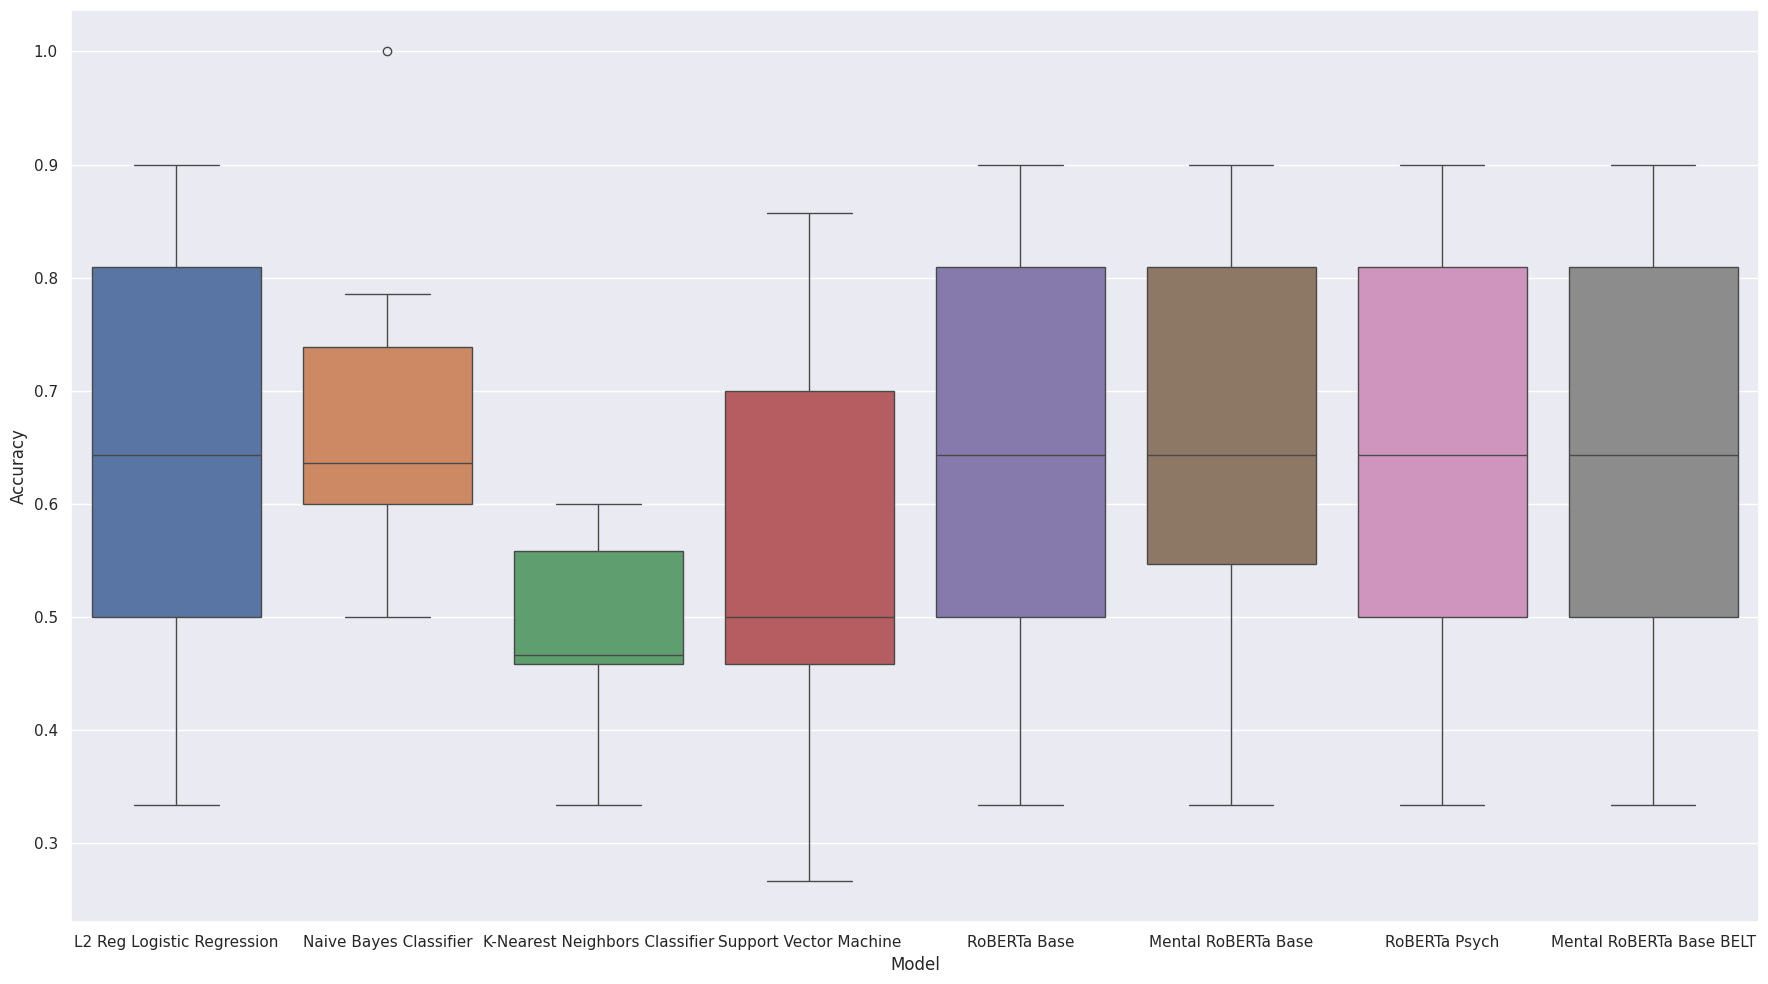

In [6]:
plot_k_fold_results('Accuracy', model2accuracies)

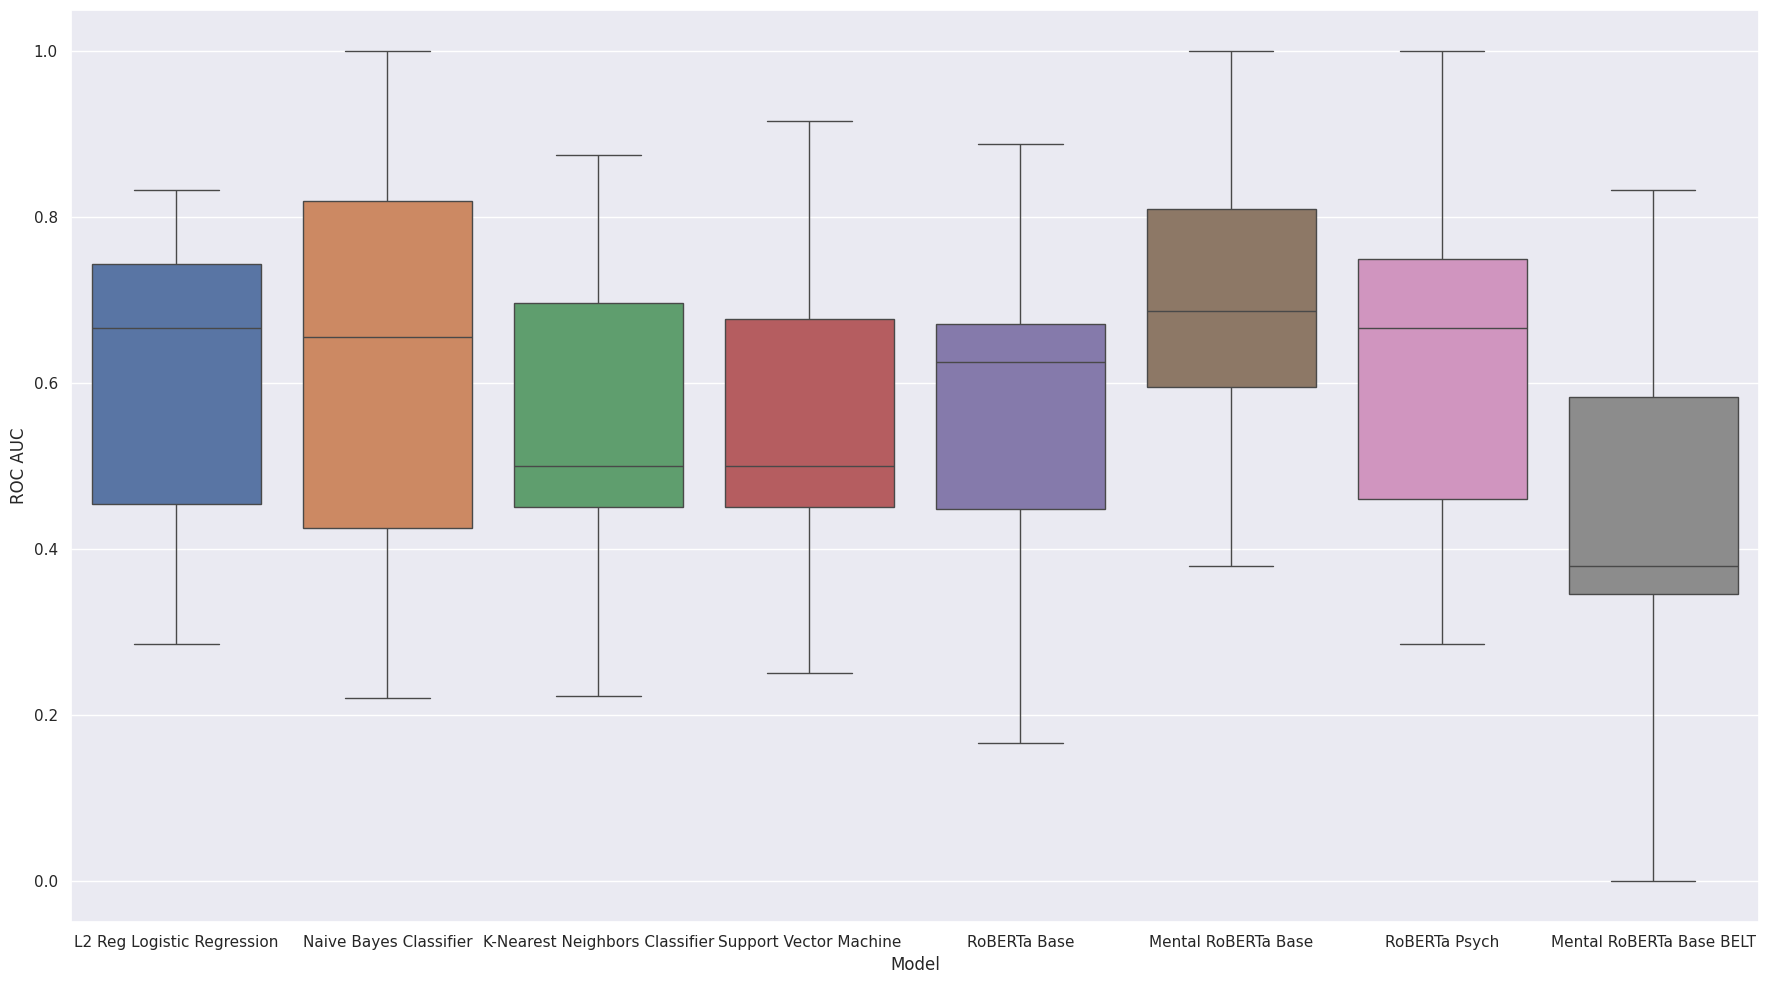

In [7]:
plot_k_fold_results('ROC AUC', model2roc_aucs)

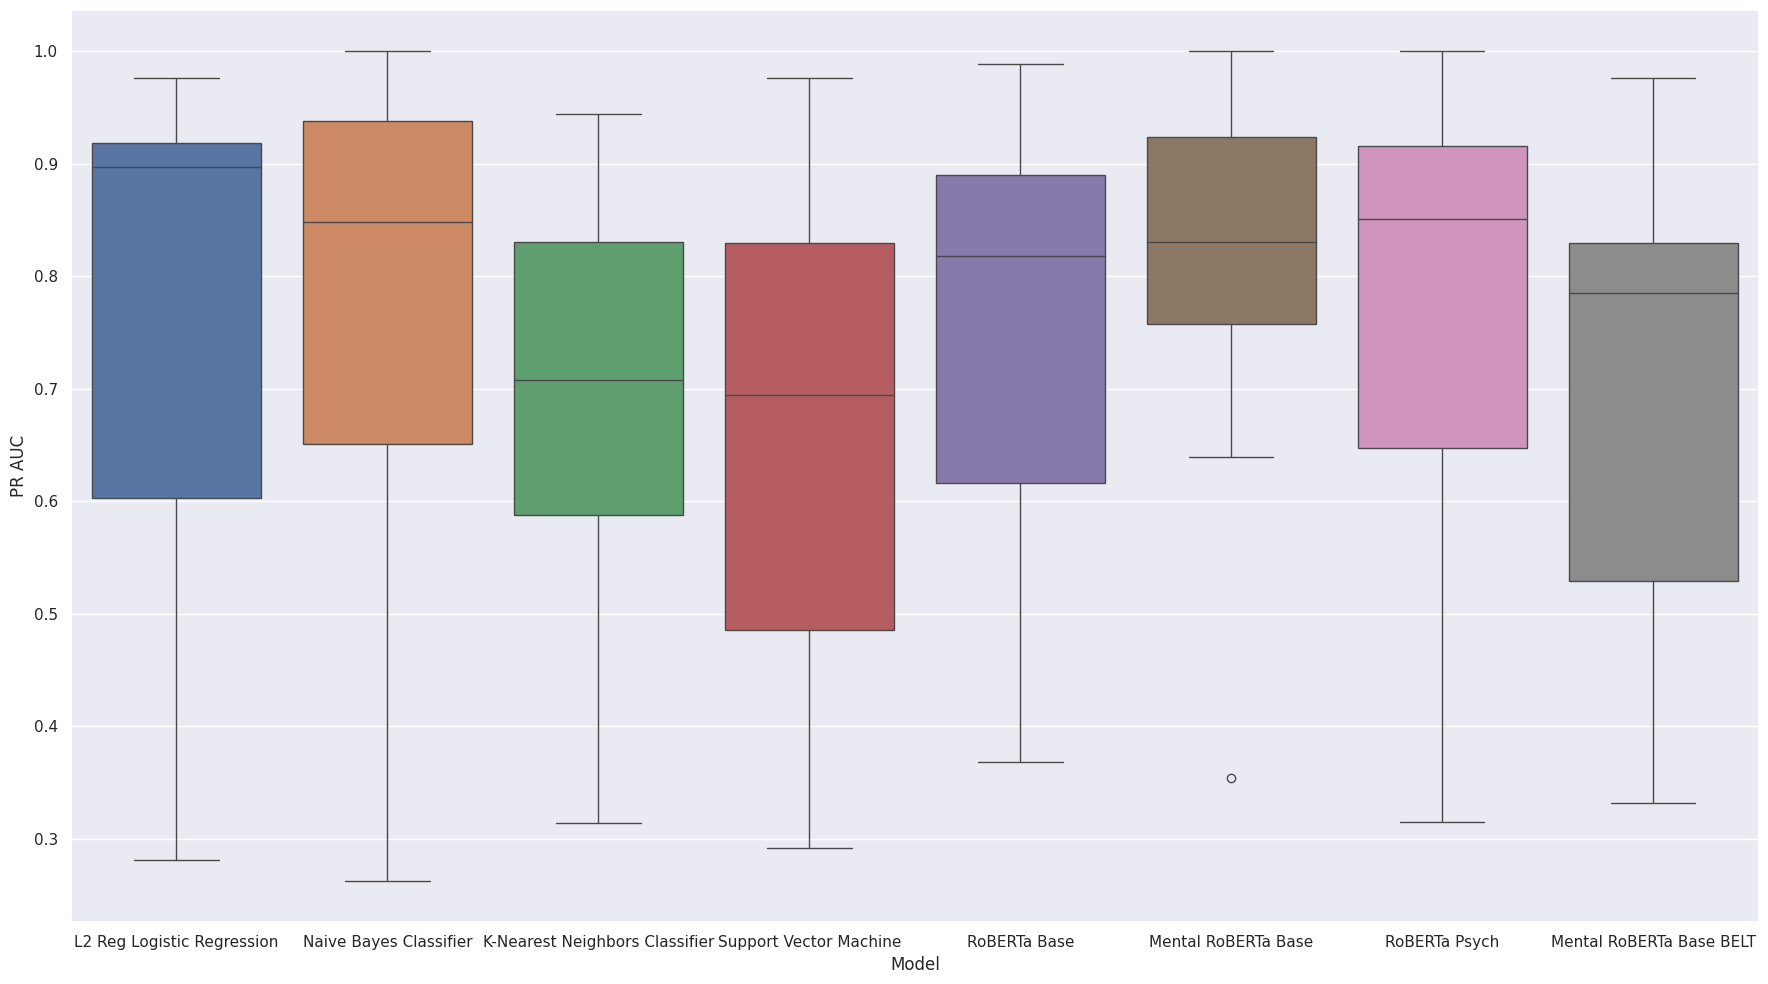

In [8]:
plot_k_fold_results('PR AUC', model2aps)

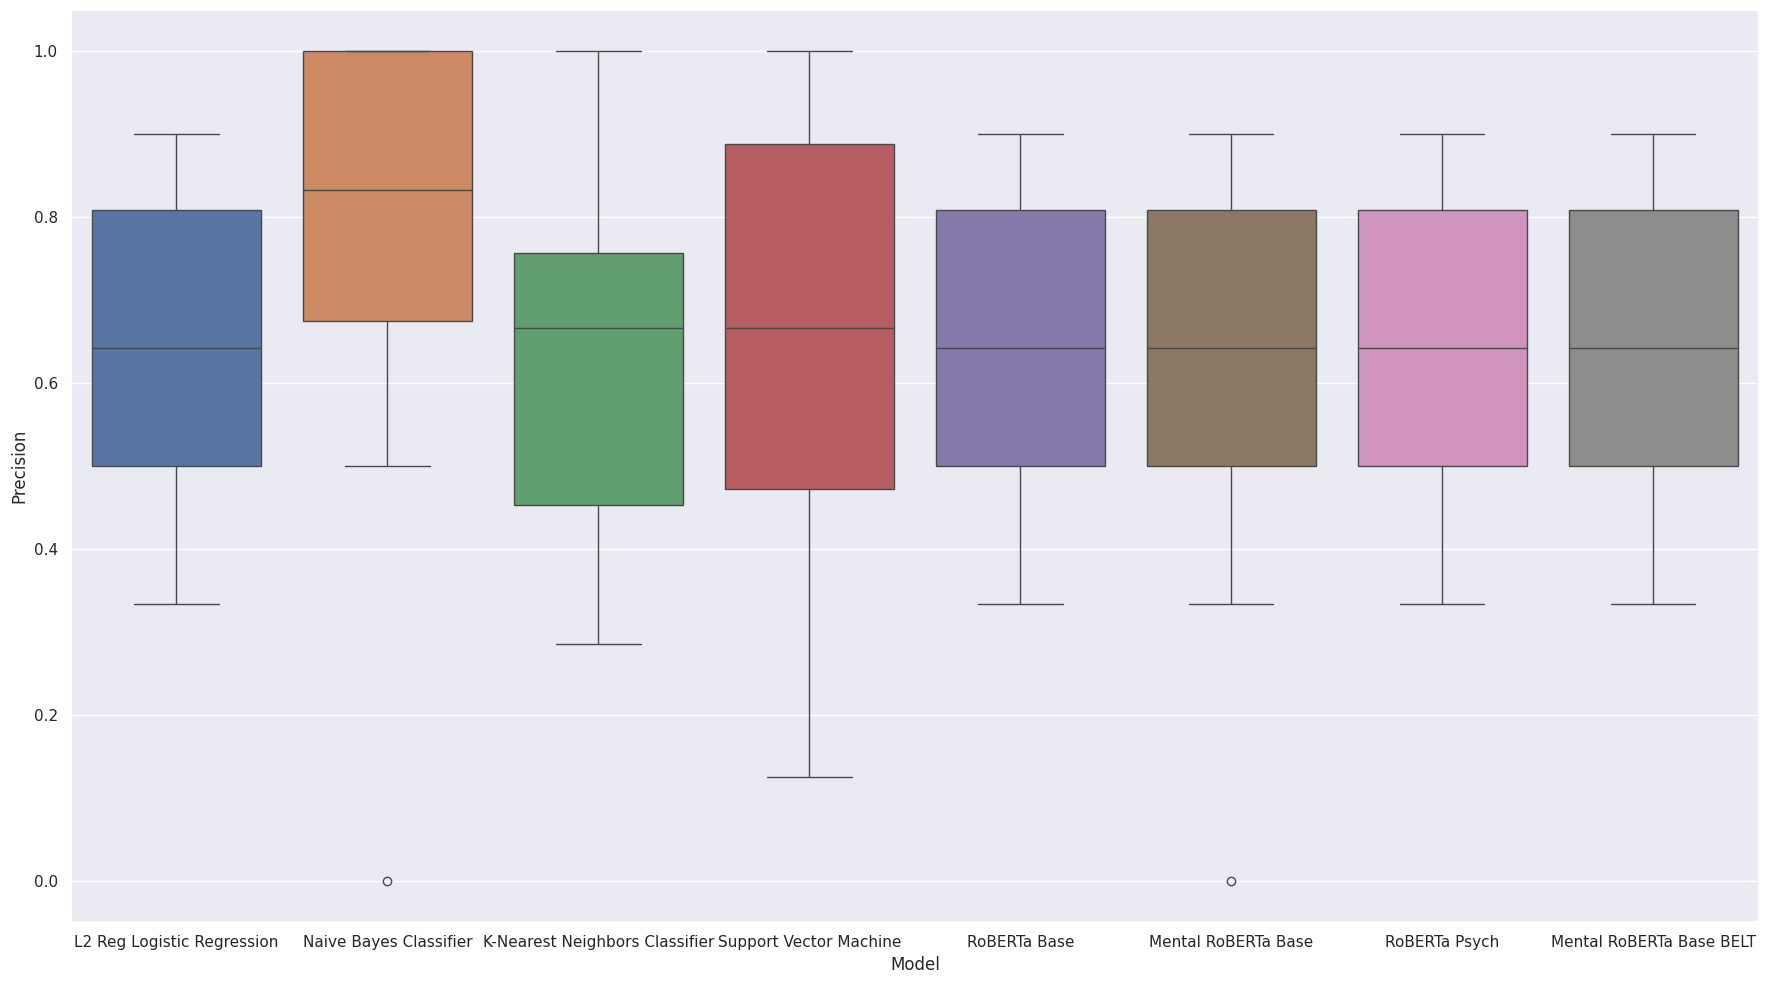

In [9]:
plot_k_fold_results('Precision', model2precisions)

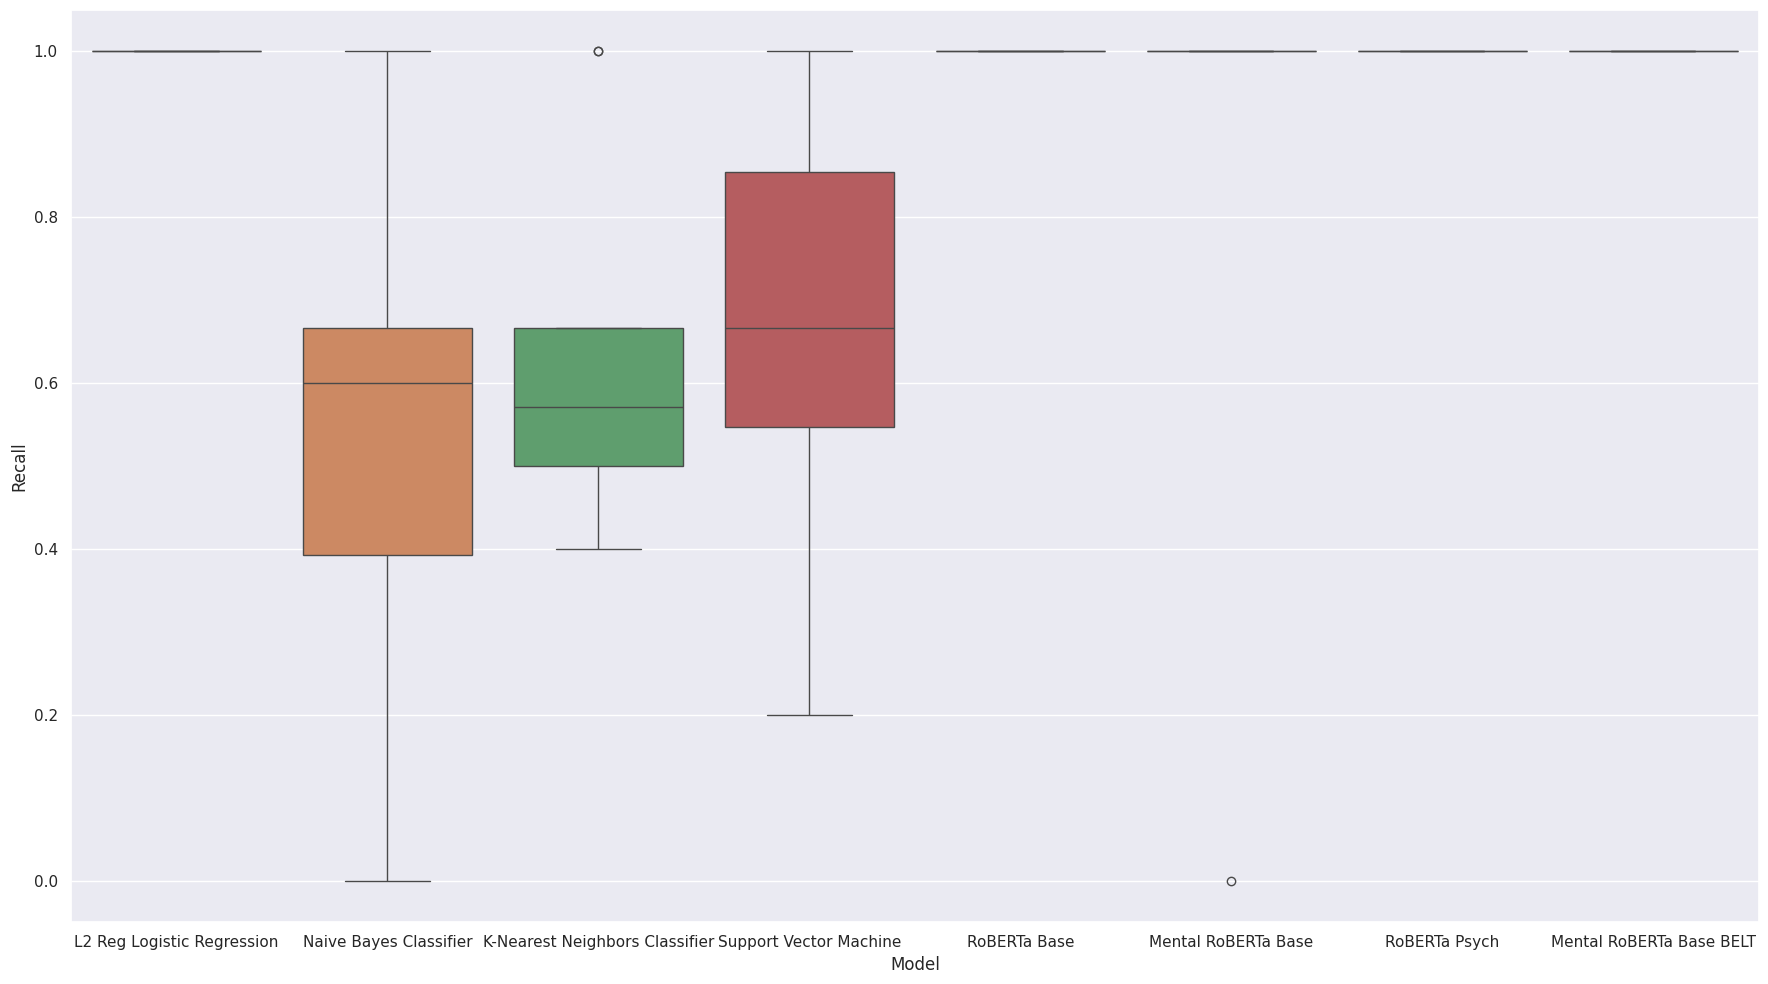

In [10]:
plot_k_fold_results('Recall', model2recalls)

In [11]:
def plot_bar_95_ci_boot(metric_name, metric_dict):
    
    sns.set(rc={'figure.figsize':(18, 10)})
    results = {name: metric_dict[model] for model, name in all_model_names.items()}
    data = pd.DataFrame(results)
    plt.clf()
    sns.barplot(
        data=data,
        n_boot=10000,
        errorbar=('ci', 95) # uses percentile interval from bootstrap
    )
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_bar_95_ci_boot('Accuracy', model2accuracies)

In [ ]:
plot_bar_95_ci_boot('ROC AUC', model2roc_aucs)

In [ ]:
plot_bar_95_ci_boot('PR AUC', model2aps)

In [ ]:
plot_bar_95_ci_boot('Precision', model2precisions)

In [ ]:
plot_bar_95_ci_boot('Recall', model2recalls)